# 21cm Line Emission Simulations, with Different Backends

## This notebook demonstrates how to run a 21cm line emission simulation, to obtain visibilities and dirty images, and create a mosaic of pointings.

## For more details, see main code on `line_emission.py`

In [3]:
!export HDF5_USE_FILE_LOCKING='FALSE'

In [4]:
from datetime import datetime, timedelta
from pathlib import Path

import numpy as np
from astropy import units as u
from astropy.coordinates import SkyCoord
from typing import List
from ska_sdp_datamodels.image.image_model import Image as RASCILImage
import matplotlib.pyplot as plt


from karabo.data.external_data import HISourcesSmallCatalogDownloadObject
from karabo.imaging.image import Image, ImageMosaicker
from karabo.imaging.imager_base import DirtyImagerConfig
from karabo.simulation.interferometer import FilterUnits, InterferometerSimulation
from karabo.simulation.line_emission import (
    CircleSkyRegion,
    line_emission_pipeline,
    generate_gaussian_beam_data,
    gaussian_beam_fwhm_for_frequency,
)
from karabo.simulation.observation import Observation
from karabo.simulation.sky_model import SkyModel
from karabo.simulation.telescope import Telescope
from karabo.simulator_backend import SimulatorBackend
from karabo.util.file_handler import FileHandler

In [5]:
# Image details
npixels = 4096
image_width_degrees = 2
cellsize_radians = np.radians(image_width_degrees) / npixels

# The number of time steps is then determined as total_length / integration_time.
observation_length = timedelta(seconds=10000)  # 14400 = 4hours
integration_time = timedelta(seconds=10000)

output_base_directory = Path(
    FileHandler().get_tmp_dir(
        prefix="line-emission-",
        purpose="Example line emission simulation",
    )
)

Creating /tmp/karabo-STM-jennifer-QnmZy3ppP6/line-emission-DsxOH7bPIX for Example line emission simulation


In [6]:
# Define observation pointings
pointings = [
    CircleSkyRegion(
        radius=2 * u.deg, center=SkyCoord(ra=20, dec=-30, unit="deg", frame="icrs")
    ),
    CircleSkyRegion(
        radius=2 * u.deg,
        center=SkyCoord(ra=20, dec=-31.4, unit="deg", frame="icrs"),
    ),
    CircleSkyRegion(
        radius=2 * u.deg,
        center=SkyCoord(ra=21.4, dec=-30, unit="deg", frame="icrs"),
    ),
    CircleSkyRegion(
        radius=2 * u.deg,
        center=SkyCoord(ra=21.4, dec=-31.4, unit="deg", frame="icrs"),
    ),
]

In [7]:
# Primary beam settings
should_apply_primary_beam = False

# Create interferometer simulation
if should_apply_primary_beam:
    beam_type = "Gaussian beam"
    # Options: "Aperture array", "Isotropic beam", "Gaussian beam", "VLA (PBCOR)"
    gaussian_fwhm = 50  # Degrees
    gaussian_ref_freq = 8e8  # Hz
else:
    beam_type = "Isotropic beam"
    gaussian_fwhm = 0
    gaussian_ref_freq = 0

In [8]:
# Load catalog of sources
catalog_path = HISourcesSmallCatalogDownloadObject().get()
print(catalog_path)
sky = SkyModel.get_sky_model_from_h5_to_xarray(
    path=catalog_path,
)

/home/jennifer/.cache/karabo-LTM-jennifer-BQmVRu78l0/objects-download-IzWvEC4tro/surveys/hi-small/HI_sources_small_catalog_v0.h5


In [9]:
# Define observation channels and duration
observation = Observation(
    start_date_and_time=datetime(2000, 3, 20, 12, 6, 39),
    length=observation_length,
    number_of_time_steps=int(
        observation_length.total_seconds() / integration_time.total_seconds()
    ),
    start_frequency_hz=7e8,
    frequency_increment_hz=8e7,
    number_of_channels=2,
)

In [10]:
# Instantiate interferometer
# Leave time_average_sec as 10, since OSKAR examples use 10.
# Not sure of the meaning of this parameter.
interferometer = InterferometerSimulation(
    time_average_sec=10,
    ignore_w_components=True,
    uv_filter_max=10000,
    uv_filter_units=FilterUnits.Metres,
    use_gpus=True,
    station_type=beam_type,
    gauss_beam_fwhm_deg=gaussian_fwhm,
    gauss_ref_freq_hz=gaussian_ref_freq,
    use_dask=False,
)

## Simulation: compute visibilities and dirty images (first, without primary beam effects)

In [11]:
%%time
# Run pipeline for each of the available backends
backend_to_dirty_images = {}

dirty_imager_config = DirtyImagerConfig(
    imaging_npixel=npixels,
    imaging_cellsize=cellsize_radians,
)

for simulator_backend, telescope_name in (
    (SimulatorBackend.OSKAR, "SKA1MID"),
    (SimulatorBackend.RASCIL, "MID"),
):
    telescope = Telescope.constructor(telescope_name, backend=simulator_backend)

    visibilities, dirty_images = line_emission_pipeline(
        output_base_directory=output_base_directory,
        pointings=pointings,
        sky_model=sky,
        observation_details=observation,
        telescope=telescope,
        interferometer=interferometer,
        simulator_backend=simulator_backend,
        dirty_imager_config=dirty_imager_config,
        primary_beams=None,
    )

    backend_to_dirty_images[simulator_backend] = dirty_images

print("Done with line emission pipelines")

Selected backend: SimulatorBackend.OSKAR
Creating /tmp/karabo-STM-jennifer-QnmZy3ppP6/line-emission-DsxOH7bPIX directory if it does not exist yet.
Computing visibilities...
Processing frequency channel 0...
Processing pointing 0...
Matched path /tmp/karabo-STM-jennifer-QnmZy3ppP6/line-emission-DsxOH7bPIX/visibilities_f0_p0.MS to format MS
Saved visibility to /tmp/karabo-STM-jennifer-QnmZy3ppP6/line-emission-DsxOH7bPIX/visibilities_f0_p0.MS
Processing pointing 1...
Matched path /tmp/karabo-STM-jennifer-QnmZy3ppP6/line-emission-DsxOH7bPIX/visibilities_f0_p1.MS to format MS
Saved visibility to /tmp/karabo-STM-jennifer-QnmZy3ppP6/line-emission-DsxOH7bPIX/visibilities_f0_p1.MS
Processing pointing 2...
Matched path /tmp/karabo-STM-jennifer-QnmZy3ppP6/line-emission-DsxOH7bPIX/visibilities_f0_p2.MS to format MS
Saved visibility to /tmp/karabo-STM-jennifer-QnmZy3ppP6/line-emission-DsxOH7bPIX/visibilities_f0_p2.MS
Processing pointing 3...
Matched path /tmp/karabo-STM-jennifer-QnmZy3ppP6/line-emi

Selected backend: SimulatorBackend.RASCIL
Creating /tmp/karabo-STM-jennifer-QnmZy3ppP6/line-emission-DsxOH7bPIX directory if it does not exist yet.
Computing visibilities...
Processing frequency channel 0...
Processing pointing 0...
Matched path /tmp/karabo-STM-jennifer-QnmZy3ppP6/line-emission-DsxOH7bPIX/visibilities_f0_p0.MS to format MS
Processing pointing 1...
Matched path /tmp/karabo-STM-jennifer-QnmZy3ppP6/line-emission-DsxOH7bPIX/visibilities_f0_p1.MS to format MS
Processing pointing 2...
Matched path /tmp/karabo-STM-jennifer-QnmZy3ppP6/line-emission-DsxOH7bPIX/visibilities_f0_p2.MS to format MS
Processing pointing 3...
Matched path /tmp/karabo-STM-jennifer-QnmZy3ppP6/line-emission-DsxOH7bPIX/visibilities_f0_p3.MS to format MS
Processing frequency channel 1...
Processing pointing 0...
Matched path /tmp/karabo-STM-jennifer-QnmZy3ppP6/line-emission-DsxOH7bPIX/visibilities_f1_p0.MS to format MS
Processing pointing 1...
Matched path /tmp/karabo-STM-jennifer-QnmZy3ppP6/line-emission-

In [12]:
%%time
# Create mosaics of pointings for each frequency channel
mosaicker = ImageMosaicker()

backend_to_mosaics = {}

for simulator_backend, dirty_images in backend_to_dirty_images.items():
    print(f"Computing mosaic for  simulator_backend = { simulator_backend.name }")
    backend_to_mosaics[simulator_backend] = []

    for index_freq in range(observation.number_of_channels):
        mosaic, _ = mosaicker.mosaic(dirty_images[index_freq])
        backend_to_mosaics[simulator_backend].append(mosaic)

Computing mosaic for  simulator_backend = OSKAR
Creating /tmp/karabo-STM-jennifer-QnmZy3ppP6/Image-PLCwRc9GK6 for restored fits-path
Creating /tmp/karabo-STM-jennifer-QnmZy3ppP6/Image-1RtfCih7rv for restored fits-path
Computing mosaic for  simulator_backend = RASCIL
Creating /tmp/karabo-STM-jennifer-QnmZy3ppP6/Image-QA8mbso0Aw for restored fits-path
Creating /tmp/karabo-STM-jennifer-QnmZy3ppP6/Image-TIHkXn4mnN for restored fits-path
CPU times: user 2min, sys: 24.3 s, total: 2min 24s
Wall time: 2min 24s


In [13]:
# Add all mosaics across frequency channels to create one final mosaic image
backend_to_summed_mosaics = {}

for simulator_backend, mosaics in backend_to_mosaics.items():
    summed_mosaic = Image(
        data=sum(m.data for m in mosaics),
        header=mosaics[0].header,
    )
    backend_to_summed_mosaics[simulator_backend] = summed_mosaic

Creating /tmp/karabo-STM-jennifer-QnmZy3ppP6/Image-mIOIMqCX9A for restored fits-path
Creating /tmp/karabo-STM-jennifer-QnmZy3ppP6/Image-JtSv72K1bv for restored fits-path


## Visualization of dirty images and mosaics

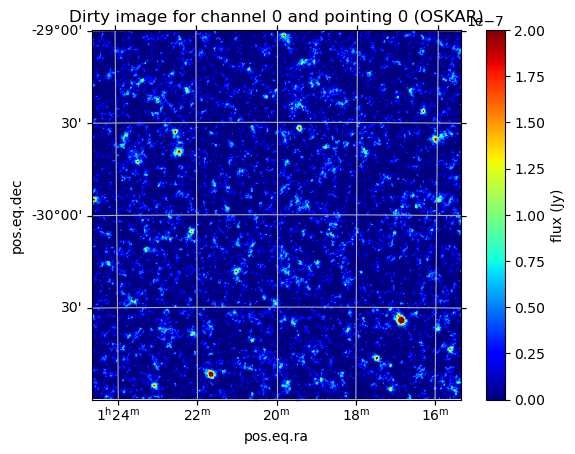

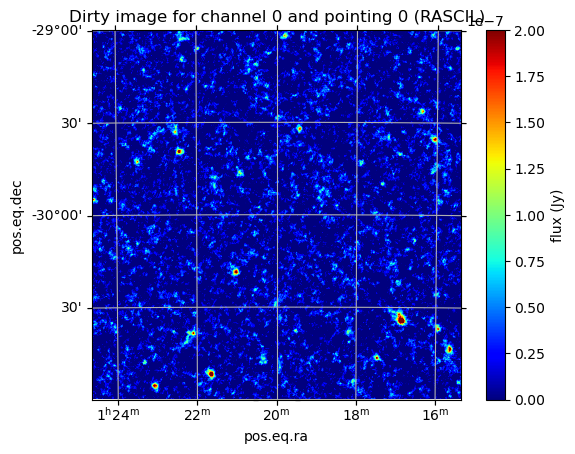

In [14]:
%matplotlib inline
backend_to_dirty_images[SimulatorBackend.OSKAR][0][0].plot(
    block=True,
    vmin=0,
    vmax=2e-7,
    title="Dirty image for channel 0 and pointing 0 (OSKAR)",
)

backend_to_dirty_images[SimulatorBackend.RASCIL][0][0].plot(
    block=True,
    vmin=0,
    vmax=2e-7,
    title="Dirty image for channel 0 and pointing 0 (RASCIL)",
)

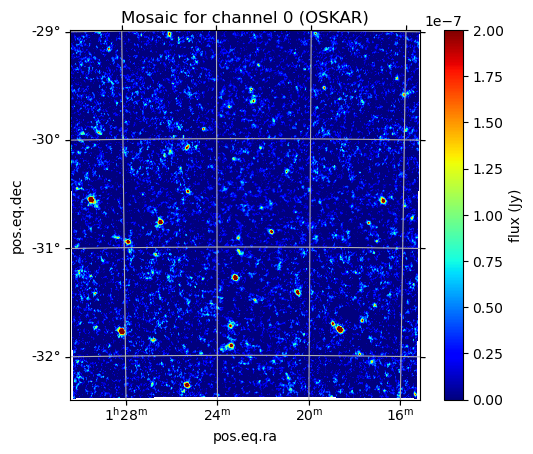

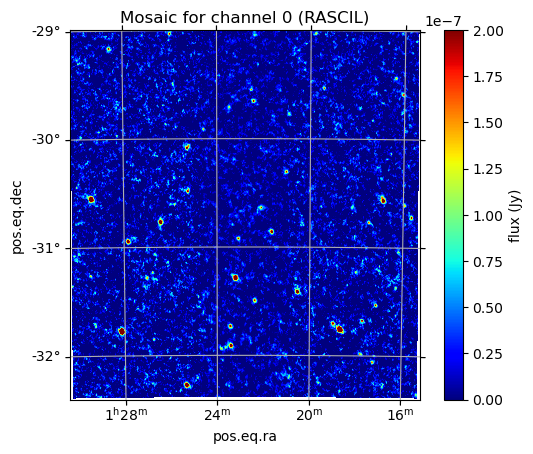

In [15]:
%matplotlib inline
backend_to_mosaics[SimulatorBackend.OSKAR][0].plot(
    block=True,
    vmin=0,
    vmax=2e-7,
    title="Mosaic for channel 0 (OSKAR)",
)
backend_to_mosaics[SimulatorBackend.RASCIL][0].plot(
    block=True,
    vmin=0,
    vmax=2e-7,
    title="Mosaic for channel 0 (RASCIL)",
)

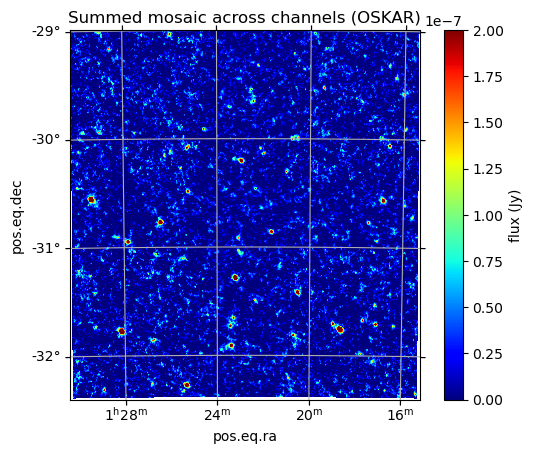

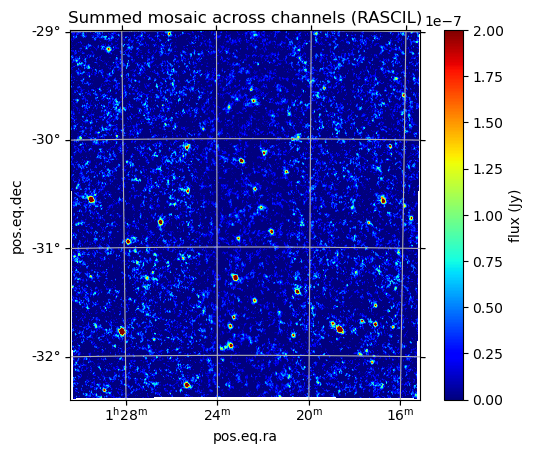

In [16]:
%matplotlib inline
backend_to_summed_mosaics[SimulatorBackend.OSKAR].plot(
    block=True,
    vmin=0,
    vmax=2e-7,
    title="Summed mosaic across channels (OSKAR)",
)
backend_to_summed_mosaics[SimulatorBackend.RASCIL].plot(
    block=True,
    vmin=0,
    vmax=2e-7,
    title="Summed mosaic across channels (RASCIL)",
)

## Comparison of mosaics for different backends

Creating /tmp/karabo-STM-jennifer-QnmZy3ppP6/Image-REKuMdmZuJ for restored fits-path


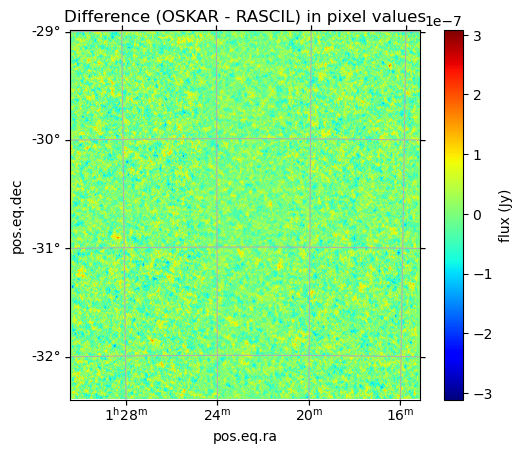

In [17]:
%matplotlib inline

# Compute difference in pixel values between mosaics from different backends
difference_in_data = (
    backend_to_summed_mosaics[SimulatorBackend.OSKAR].data
    - backend_to_summed_mosaics[SimulatorBackend.RASCIL].data
)
difference_header = backend_to_summed_mosaics[SimulatorBackend.OSKAR].header

difference_image = Image(
    data=np.nan_to_num(difference_in_data),  # To convert NaN into 0 at borders of image
    header=difference_header,
)

difference_image.plot(
    block=True,
    title="Difference (OSKAR - RASCIL) in pixel values",
)

# Primary Beam Effects

## We instantiate different interferometers (with / without primary beam effects), and provide primary beams (Gaussian, in this example) to the `line_emission_pipeline`

## NOTE!

- OSKAR only support Gaussian beams, and ignores the `primary_beams` array, using only the `gaussian_*` parameters in `InterferometerSimulation`.

- RASCIL ignores the `gaussian_*` parameters in `InterferometerSimulation`, and instead uses the `primary_beams` array provided into `line_emission_pipeline`

In [18]:
# Instantiate interferometers
interferometer_without_primary_beam = InterferometerSimulation(
    time_average_sec=10,
    ignore_w_components=True,
    uv_filter_max=10000,
    uv_filter_units=FilterUnits.Metres,
    use_gpus=True,
    station_type="Isotropic beam",
    gauss_beam_fwhm_deg=0,
    gauss_ref_freq_hz=0,
    use_dask=False,
)

interferometer_with_primary_beam = InterferometerSimulation(
    time_average_sec=10,
    ignore_w_components=True,
    uv_filter_max=10000,
    uv_filter_units=FilterUnits.Metres,
    use_gpus=True,
    station_type="Gaussian beam",
    gauss_beam_fwhm_deg=gaussian_fwhm,
    gauss_ref_freq_hz=gaussian_ref_freq,
    use_dask=False,
)

## Generate data for primary beams (2D np.array for each frequency channel) -> here, we use Gaussian beams

In [19]:
primary_beams: List[RASCILImage] = []

# Compute frequency channels
frequency_channel_starts = np.linspace(
    observation.start_frequency_hz,
    observation.start_frequency_hz
    + observation.frequency_increment_hz * observation.number_of_channels,
    num=observation.number_of_channels,
    endpoint=False,
)

# RASCIL supports custom primary beams
# Here we create a sample beam (Gaussian)
# as a 2D np.array of shape (npixels, npixels)
for frequency in frequency_channel_starts:
    fwhm_degrees = gaussian_beam_fwhm_for_frequency(frequency)
    fwhm_pixels = fwhm_degrees / np.degrees(dirty_imager_config.imaging_cellsize)

    primary_beam = generate_gaussian_beam_data(
        fwhm_pixels=fwhm_pixels,
        x_size=dirty_imager_config.imaging_npixel,
        y_size=dirty_imager_config.imaging_npixel,
    )
    primary_beams.append(primary_beam)

## We then run the simulations with and without primary beams, and compare the resulting dirty images

In [23]:
backend_to_dirty_images_without_primary_beams = {}
backend_to_dirty_images_with_primary_beams = {}

for simulator_backend, telescope_name in (
    (SimulatorBackend.OSKAR, "SKA1MID"),
    (SimulatorBackend.RASCIL, "MID"),
):
    telescope = Telescope.constructor(telescope_name, backend=simulator_backend)

    (
        visibilities_without_primary_beam,
        dirty_images_without_primary_beam,
    ) = line_emission_pipeline(
        output_base_directory=output_base_directory,
        pointings=pointings,
        sky_model=sky,
        observation_details=observation,
        telescope=telescope,
        interferometer=interferometer_without_primary_beam,
        simulator_backend=simulator_backend,
        dirty_imager_config=dirty_imager_config,
        primary_beams=None,
    )

    backend_to_dirty_images_without_primary_beams[
        simulator_backend
    ] = dirty_images_without_primary_beam

    (
        visibilities_with_primary_beam,
        dirty_images_with_primary_beam,
    ) = line_emission_pipeline(
        output_base_directory=output_base_directory,
        pointings=pointings,
        sky_model=sky,
        observation_details=observation,
        telescope=telescope,
        interferometer=interferometer_without_primary_beam,
        simulator_backend=simulator_backend,
        dirty_imager_config=dirty_imager_config,
        primary_beams=primary_beams,
    )

    backend_to_dirty_images_with_primary_beams[
        simulator_backend
    ] = dirty_images_with_primary_beam

Selected backend: SimulatorBackend.OSKAR
Creating /tmp/karabo-STM-jennifer-QnmZy3ppP6/line-emission-DsxOH7bPIX directory if it does not exist yet.
Computing visibilities...
Processing frequency channel 0...
Processing pointing 0...


RuntimeError: oskar_interferometer_check_init() failed with code 999 (unknown error).

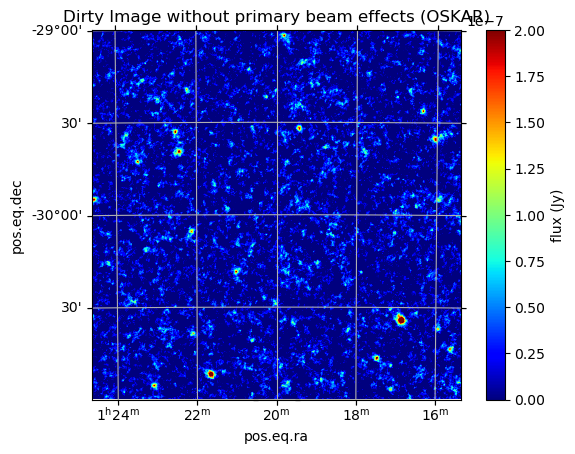

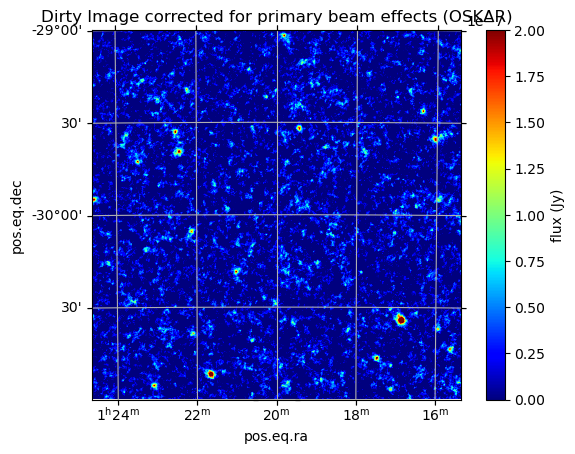

In [21]:
%matplotlib inline
backend_to_dirty_images_without_primary_beams[SimulatorBackend.OSKAR][0][0].plot(
    block=True,
    vmin=0,
    vmax=2e-7,
    title="Dirty Image without primary beam effects (OSKAR)",
)

backend_to_dirty_images_corrected_for_primary_beams[SimulatorBackend.OSKAR][0][0].plot(
    block=True,
    vmin=0,
    vmax=2e-7,
    title="Dirty Image corrected for primary beam effects (OSKAR)",
)

## Fractional difference between image without beam and image corrected for primary beam -> ideally, there should be no differences

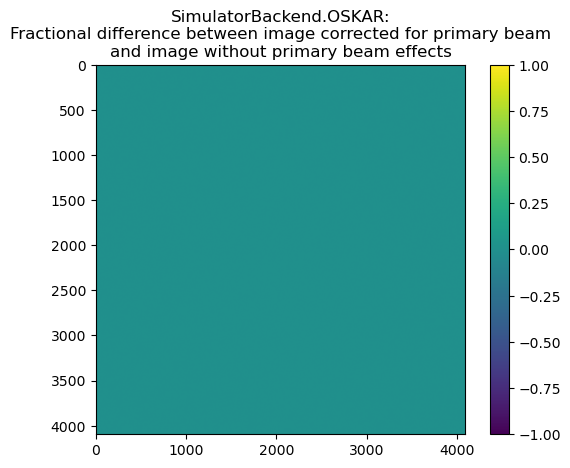

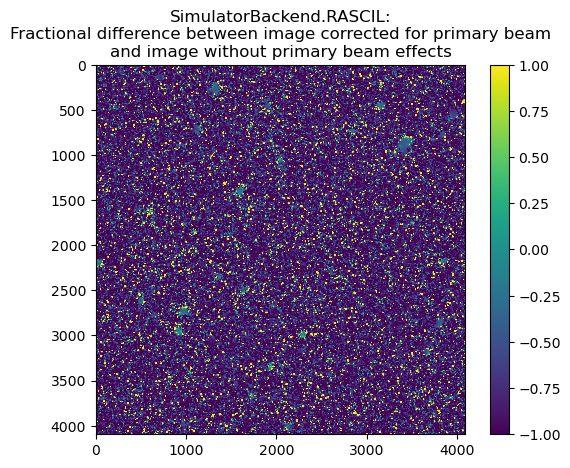

<Figure size 640x480 with 0 Axes>

In [22]:
%matplotlib inline

for simulator_backend in (SimulatorBackend.OSKAR, SimulatorBackend.RASCIL):
    fractional_difference = (
        backend_to_dirty_images_corrected_for_primary_beams[simulator_backend][0][
            0
        ].data
        / backend_to_dirty_images_without_primary_beams[simulator_backend][0][0].data
        - 1
    )

    plt.imshow(
        fractional_difference[0][0],
        vmin=-1,
        vmax=1,
    )
    plt.title(
        f"{simulator_backend}:\nFractional difference between image corrected for primary beam\nand image without primary beam effects",
    )
    plt.colorbar()
    plt.show()
    plt.clf()